In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pycountry_convert as pc
from thefuzz import process
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

urls = {
    "EU": "~OWID_EUR",
    "SA": "~OWID_SAM",
    "NA": "~OWID_NAM",
    "OC": "~OWID_OCE",
    "AF": "~OWID_AFR",
    "AS": "~OWID_ASI"
}

base_url = "https://ourworldindata.org/grapher/kaya-identity-co2.csv"
params = "?v=1&csvType=filtered&useColumnShortNames=true&time=2000..latest&country="

dfs = []

for label, code in urls.items():
    url = f"{base_url}{params}{code}"
    df = pd.read_csv(url, storage_options={'User-Agent': 'Our World In Data data fetch/1.0'})
    df = df[["Entity", "Year", "emissions_total_per_unit_energy"]]
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
combined_df= combined_df.rename(columns={"Entity": "Continent", "emissions_total_per_unit_energy": "carbon_intensity"})

print(combined_df.head())

  Continent  Year  carbon_intensity
0    Europe  2000          0.199263
1    Europe  2001          0.200748
2    Europe  2002          0.200975
3    Europe  2003          0.202306
4    Europe  2004          0.200783


In [2]:
df = pd.read_csv("https://ourworldindata.org/grapher/kaya-identity-co2.csv?v=1&csvType=full&useColumnShortNames=false", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})
df = df[df['Year'] >= 2000]
print(df)

            Entity Code  Year  Annual CO₂ emissions  \
51     Afghanistan  AFG  2000            1047127.94   
52     Afghanistan  AFG  2001            1069098.00   
53     Afghanistan  AFG  2002            1340995.00   
54     Afghanistan  AFG  2003            1559602.00   
55     Afghanistan  AFG  2004            1237247.00   
...            ...  ...   ...                   ...   
67282     Zimbabwe  ZWE  2019           10262950.00   
67283     Zimbabwe  ZWE  2020            8494503.00   
67284     Zimbabwe  ZWE  2021           10203630.00   
67285     Zimbabwe  ZWE  2022           10424940.00   
67286     Zimbabwe  ZWE  2023           11164030.00   

       Primary energy consumption per GDP (kWh/$)  GDP per capita  \
51                                       0.524080       502.37274   
52                                       0.423189       489.68200   
53                                       0.235479       796.81660   
54                                       0.247109       842.805

In [39]:
df['GDP'] = df['GDP per capita'] * df['Population (historical)']

In [40]:
df = df.dropna(subset=["Code"])

In [41]:
def get_continent(country_name):
    try:
        country_code = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return 'Unknown'

In [42]:
df['Continent'] = df['Entity'].apply(get_continent)

In [43]:
unknown_entities = df[df['Continent'] == "Unknown"]['Entity'].unique()
df = df[~df['Entity'].isin(unknown_entities)]

In [44]:
print("Number of unique entities:", df['Entity'].nunique())

Number of unique entities: 226


In [46]:
ssp_df = pd.read_csv("data/ssp1_gdp.csv")
ssp_regions = ssp_df['Region'].unique().tolist()

In [47]:
entity_names = df['Entity'].unique()
name_mapping = {}

In [48]:
for name in entity_names:
    match, score = process.extractOne(name, ssp_regions)
    if score >= 90:
        name_mapping[name] = match

In [49]:
df['Matched_Entity'] = df['Entity'].map(name_mapping)

In [50]:
unmatched_entities = [name for name in entity_names if name not in name_mapping]

In [51]:
print("Unmatched entities:")
for name in unmatched_entities:
    print(f"- {name}")

Unmatched entities:
- Afghanistan
- Andorra
- Anguilla
- Bermuda
- British Virgin Islands
- Cape Verde
- Cayman Islands
- Christmas Island
- Cook Islands
- Falkland Islands
- Faroe Islands
- Gibraltar
- Greenland
- Guadeloupe
- Guernsey
- Isle of Man
- Jersey
- Liechtenstein
- Marshall Islands
- Martinique
- Monaco
- Montserrat
- Nauru
- Niue
- Northern Mariana Islands
- Palau
- Palestine
- Saint Kitts and Nevis
- Saint Martin (French part)
- Saint Pierre and Miquelon
- San Marino
- Svalbard and Jan Mayen
- Syria
- Tokelau
- Turks and Caicos Islands
- Tuvalu
- Venezuela
- Wallis and Futuna


In [52]:
df = df[df['Matched_Entity'].notna()]

In [53]:
df['Entity'] = df['Matched_Entity']
df = df.drop(columns=['Matched_Entity'])

In [54]:
print(f"Remaining countries: {df['Entity'].nunique()}")

Remaining countries: 186


In [55]:
columns_to_drop = [
    'Code',
    'Annual CO₂ emissions',
    '900793-annotations',
    'Annual CO₂ emissions per GDP (kg per international-$)',
    'Annual CO₂ emissions per unit energy (kg per kilowatt-hour)'
]

df = df.drop(columns=columns_to_drop, errors='ignore')

In [59]:
df = df[df['Year'] <= 2021]
df.head()

,Entity,Year,Primary energy consumption per GDP (kWh/$),GDP per capita,Population (historical),GDP,Continent
844,Albania,2000,1.949666,4808.4795,3166104.0,1.522415e+10,Europe
845,Albania,2001,1.691090,5285.8090,3147892.0,1.663916e+10,Europe
846,Albania,2002,1.731348,5608.9624,3134049.0,1.757876e+10,Europe
847,Albania,2003,1.830939,6004.6450,3118038.0,1.872271e+10,Europe
848,Albania,2004,1.834251,6419.8706,3098613.0,1.989269e+10,Europe


In [60]:
country_to_continent = df[['Entity', 'Continent']].drop_duplicates().set_index('Entity')['Continent'].to_dict()
pd.DataFrame.from_dict(country_to_continent, orient='index', columns=['Continent'])\
  .reset_index().rename(columns={'index': 'Country'})\
  .to_csv("data/country_continent_map.csv", index=False)

In [61]:
missing_values = df[
    df["Primary energy consumption per GDP (kWh/$)"].isna()
]

print(missing_values)
m=missing_values["Entity"].unique()
print(m)

        Entity  Year  Primary energy consumption per GDP (kWh/$)  \
1391     Samoa  2000                                         NaN   
1392     Samoa  2001                                         NaN   
1393     Samoa  2002                                         NaN   
1394     Samoa  2003                                         NaN   
1395     Samoa  2004                                         NaN   
...        ...   ...                                         ...   
64988  Vanuatu  2017                                         NaN   
64989  Vanuatu  2018                                         NaN   
64990  Vanuatu  2019                                         NaN   
64991  Vanuatu  2020                                         NaN   
64992  Vanuatu  2021                                         NaN   

       GDP per capita  Population (historical)  GDP Continent  
1391              NaN                  56828.0  NaN   Oceania  
1392              NaN                  57033.0  NaN   O

In [62]:
df = df.dropna(subset=[
    "Primary energy consumption per GDP (kWh/$)"
])

In [63]:
df['weighted_energy_per_GDP'] = df['Primary energy consumption per GDP (kWh/$)'] * df['GDP']

In [64]:
grouped = df.groupby(['Continent', 'Year']).agg({
    'weighted_energy_per_GDP': 'sum',
    'GDP': 'sum'
}).reset_index()

In [65]:
grouped['Primary energy consumption per GDP (kWh/$)'] = grouped['weighted_energy_per_GDP'] / grouped['GDP']

In [66]:
result_df = grouped[['Continent', 'Year', 
                     'Primary energy consumption per GDP (kWh/$)']].rename(columns={
    'Primary energy consumption per GDP (kWh/$)': 'energy_intensity'})

In [67]:
result_df = pd.merge(result_df, combined_df, on=["Continent", "Year"], how="left")
print(result_df)

         Continent  Year  energy_intensity  carbon_intensity
0           Africa  2000          1.498896          0.285067
1           Africa  2001          1.449357          0.272203
2           Africa  2002          1.377560          0.261982
3           Africa  2003          1.353365          0.274502
4           Africa  2004          1.323434          0.273831
..             ...   ...               ...               ...
127  South America  2017          1.126083          0.157972
128  South America  2018          1.121109          0.152386
129  South America  2019          1.112067          0.154764
130  South America  2020          1.107914          0.150633
131  South America  2021          1.105720          0.154200

[132 rows x 4 columns]


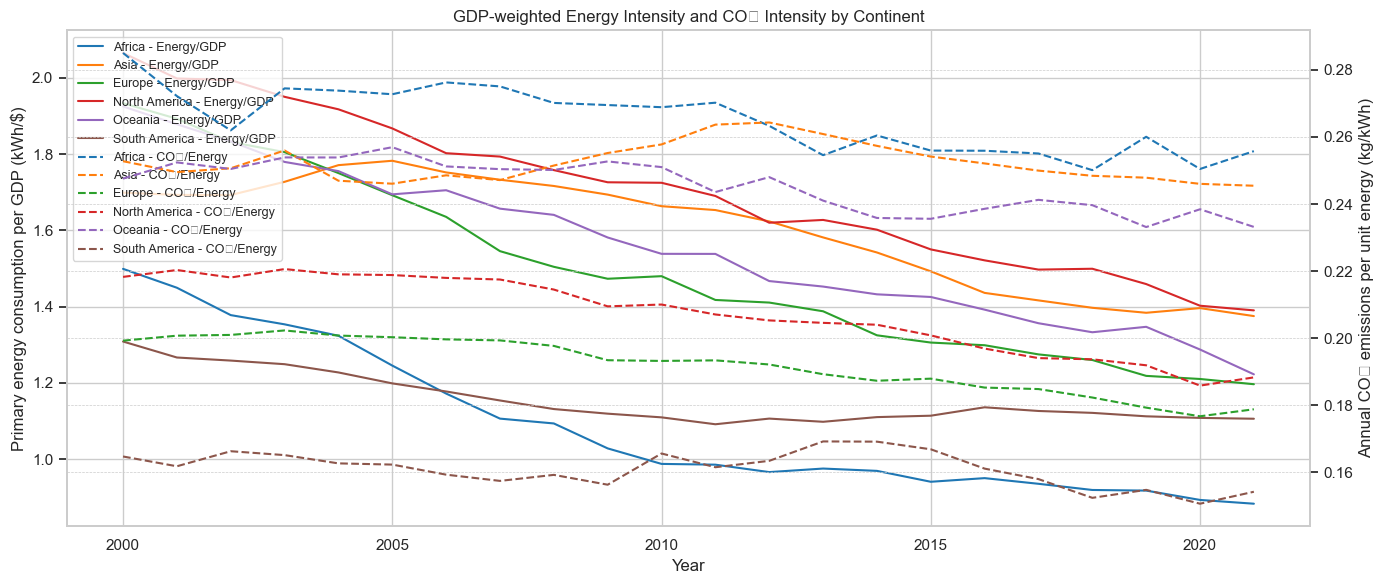

In [68]:
fig, ax1 = plt.subplots(figsize=(14, 6))
colors = plt.cm.tab10.colors
continents = result_df['Continent'].unique()
for i, continent in enumerate(continents):
    subset = result_df[result_df['Continent'] == continent]
    ax1.plot(subset['Year'], subset['energy_intensity'], 
             label=f'{continent} - Energy/GDP', color=colors[i], linestyle='-')

ax2 = ax1.twinx()

for i, continent in enumerate(continents):
    subset = result_df[result_df['Continent'] == continent]
    ax2.plot(subset['Year'], subset['carbon_intensity'], 
             label=f'{continent} - CO₂/Energy', color=colors[i], linestyle='--')

ax1.set_xlabel('Year')
ax1.set_ylabel('Primary energy consumption per GDP (kWh/$)')
ax2.set_ylabel('Annual CO₂ emissions per unit energy (kg/kWh)')
plt.title('GDP-weighted Energy Intensity and CO₂ Intensity by Continent')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [98]:
def extrapolate_to_2100(df, value_col, start_year=2022, end_year=2100, fallback_decay=0.01):  # decay rate for safety
    df = df.copy()
    df = df[df[value_col] > 0]
    df['log_val'] = np.log(df[value_col])
    X = df[['Year']]
    y = df['log_val']

    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]

    future_years = np.arange(start_year, end_year + 1)

    start_val_row = df[df['Year'] == start_year - 1]
    if start_val_row.empty:
        start_val = df[value_col].iloc[-1]
    else:
        start_val = start_val_row[value_col].values[0]

    if slope >= 0:
        
        values = start_val * np.exp(-fallback_decay * (future_years - (start_year - 1)))
    else:
        future_log_vals = model.predict(future_years.reshape(-1, 1))
        values = np.exp(future_log_vals)

    return pd.DataFrame({'Year': future_years, value_col: values})

In [99]:
all_projections = []

for continent, group in result_df.groupby("Continent"):
    ei_proj = extrapolate_to_2100(group[['Year', 'energy_intensity']], 'energy_intensity')
    ci_proj = extrapolate_to_2100(group[['Year', 'carbon_intensity']], 'carbon_intensity')
    
    merged = ei_proj.merge(ci_proj, on='Year')
    merged['Continent'] = continent
    all_projections.append(merged)

projection_df = pd.concat(all_projections, ignore_index=True)

In [100]:
print(projection_df)

     Year  energy_intensity  carbon_intensity      Continent
0    2022          0.805810          0.250815         Africa
1    2023          0.785944          0.249623         Africa
2    2024          0.766568          0.248437         Africa
3    2025          0.747669          0.247257         Africa
4    2026          0.729236          0.246082         Africa
..    ...               ...               ...            ...
469  2096          0.632061          0.130751  South America
470  2097          0.627626          0.130434  South America
471  2098          0.623223          0.130117  South America
472  2099          0.618850          0.129802  South America
473  2100          0.614508          0.129487  South America

[474 rows x 4 columns]


In [102]:
full_df = pd.concat([result_df, projection_df], ignore_index=True)
full_df = full_df.sort_values(by=['Continent', 'Year']).reset_index(drop=True)

In [103]:
print(full_df.head(10))
print(full_df.tail(10))

  Continent  Year  energy_intensity  carbon_intensity
0    Africa  2000          1.498896          0.285067
1    Africa  2001          1.449357          0.272203
2    Africa  2002          1.377560          0.261982
3    Africa  2003          1.353365          0.274502
4    Africa  2004          1.323434          0.273831
5    Africa  2005          1.245157          0.272751
6    Africa  2006          1.171736          0.276279
7    Africa  2007          1.106017          0.275088
8    Africa  2008          1.093338          0.270161
9    Africa  2009          1.027896          0.269528
         Continent  Year  energy_intensity  carbon_intensity
596  South America  2091          0.654709          0.132348
597  South America  2092          0.650115          0.132027
598  South America  2093          0.645554          0.131707
599  South America  2094          0.641024          0.131387
600  South America  2095          0.636527          0.131068
601  South America  2096          0.6320

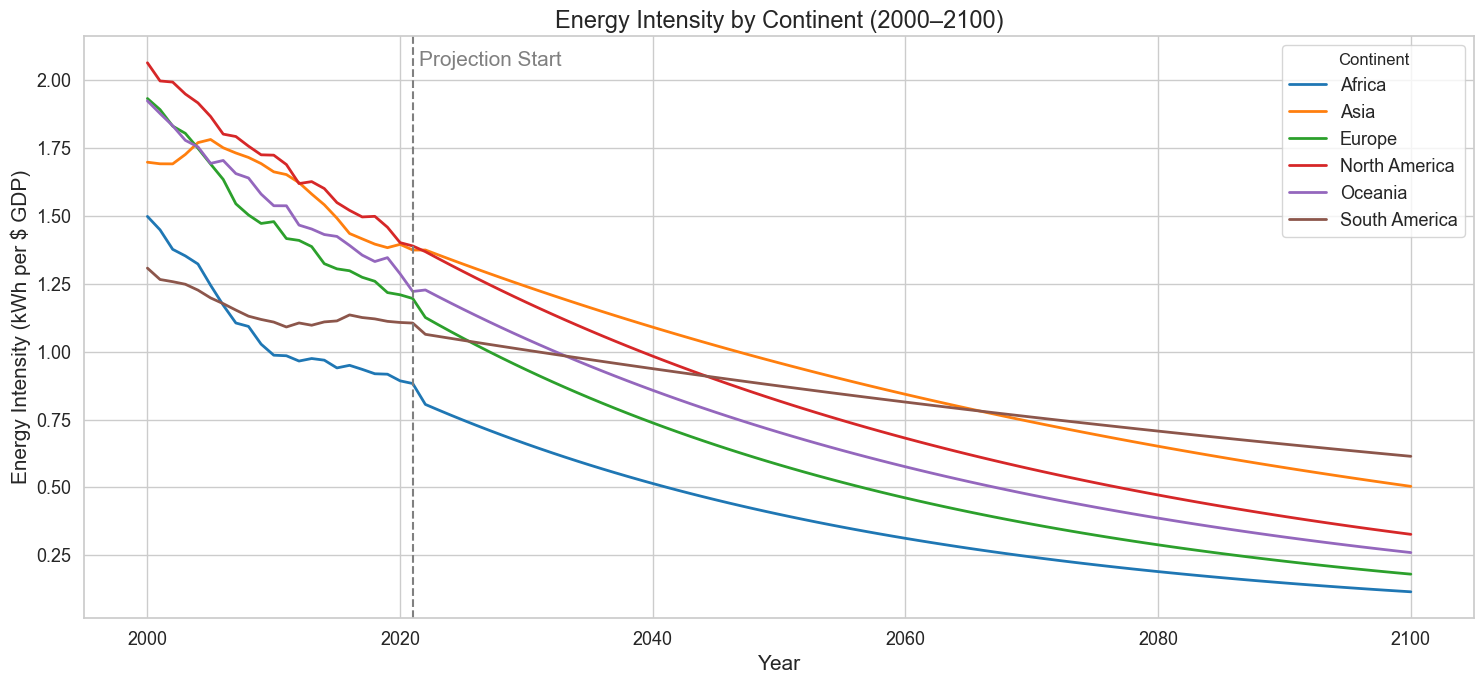

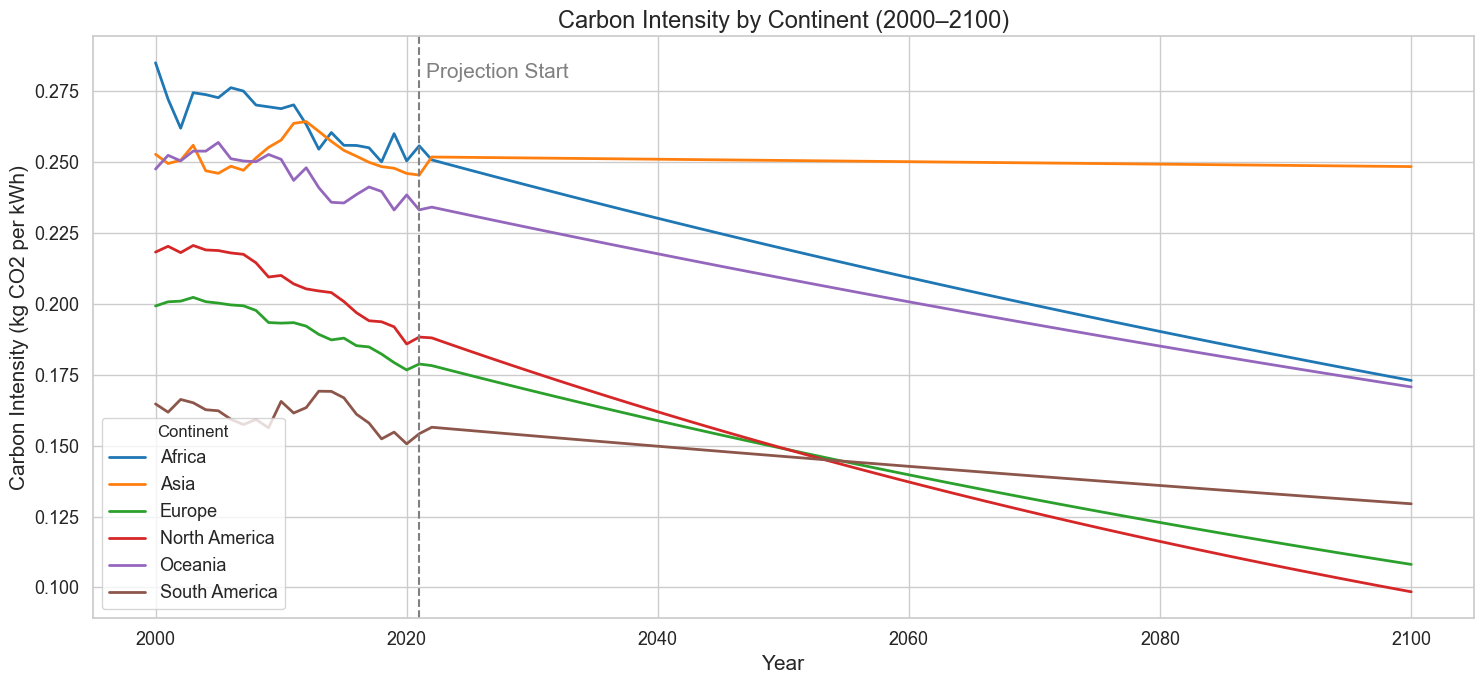

In [104]:
import seaborn as sns

sns.set(style="whitegrid")

continents = full_df['Continent'].unique()
colors = sns.color_palette("tab10", len(continents))
transition_year = 2021

def plot_intensity(df, value_col, ylabel, title):
    plt.figure(figsize=(15, 7))

    for i, continent in enumerate(continents):
        subset = df[df['Continent'] == continent]
        plt.plot(subset['Year'], subset[value_col], label=continent, color=colors[i], linewidth=2)

    plt.axvline(x=transition_year, color='gray', linestyle='--', linewidth=1.5)
    plt.text(transition_year + 0.5, plt.ylim()[1]*0.95, 'Projection Start', color='gray', fontsize=15)

    plt.title(title, fontsize=17)
    plt.xlabel("Year", fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(title="Continent", fontsize=13)
    plt.tight_layout()
    plt.show()

plot_intensity(
    full_df,
    value_col='energy_intensity',
    ylabel='Energy Intensity (kWh per $ GDP)',
    title='Energy Intensity by Continent (2000–2100)'
)

plot_intensity(
    full_df,
    value_col='carbon_intensity',
    ylabel='Carbon Intensity (kg CO2 per kWh)',
    title='Carbon Intensity by Continent (2000–2100)'
)

In [105]:
START_YEAR = 2022
END_YEAR = 2100
MIN_DECAY_RATE = 0.005
N_YEARS = 10 
def recent_trend_projection(df, value_col, start_year, end_year, min_decay_rate, n_years):
    df = df[df[value_col] > 0].copy()
    df = df.sort_values("Year")

    recent_df = df[df["Year"] >= df["Year"].max() - n_years + 1]

    recent_df["log_val"] = np.log(recent_df[value_col])
    X = recent_df[["Year"]]
    y = recent_df["log_val"]

    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]

    # minimum decay rate for safety
    if slope > -min_decay_rate:
        slope = -min_decay_rate

    start_val = df[df["Year"] == start_year - 1][value_col].values[0]
    intercept = np.log(start_val) - slope * (start_year - 1)

    future_years = np.arange(start_year, end_year + 1)
    log_predictions = intercept + slope * future_years
    values = np.exp(log_predictions)

    return pd.DataFrame({
        "Year": future_years,
        value_col: values
    })

all_proj = []

for continent, group in result_df.groupby("Continent"):
    ei_proj = recent_trend_projection(group, "energy_intensity", START_YEAR, END_YEAR, MIN_DECAY_RATE, N_YEARS)
    ci_proj = recent_trend_projection(group, "carbon_intensity", START_YEAR, END_YEAR, MIN_DECAY_RATE, N_YEARS)

    merged = ei_proj.merge(ci_proj, on="Year")
    merged["Continent"] = continent
    all_proj.append(merged)

projection_df = pd.concat(all_proj, ignore_index=True)

print(projection_df)

     Year  energy_intensity  carbon_intensity      Continent
0    2022          0.873305          0.254504         Africa
1    2023          0.863907          0.253235         Africa
2    2024          0.854611          0.251972         Africa
3    2025          0.845415          0.250715         Africa
4    2026          0.836318          0.249465         Africa
..    ...               ...               ...            ...
469  2096          0.759949          0.060110  South America
470  2097          0.756159          0.059360  South America
471  2098          0.752388          0.058619  South America
472  2099          0.748635          0.057887  South America
473  2100          0.744901          0.057165  South America

[474 rows x 4 columns]


In [106]:
full_df = pd.concat([result_df, projection_df], ignore_index=True)
full_df = full_df.sort_values(by=['Continent', 'Year']).reset_index(drop=True)
full_df.to_csv("/data/intensities.csv")

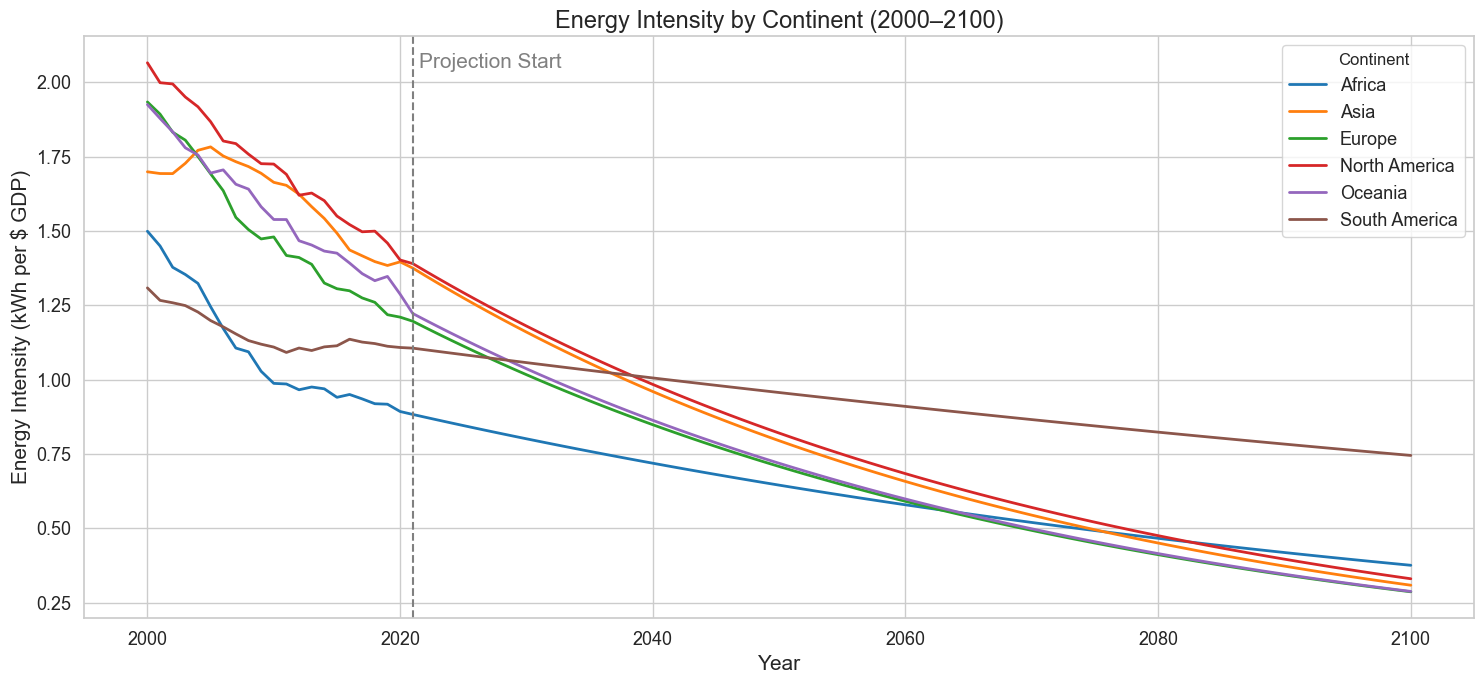

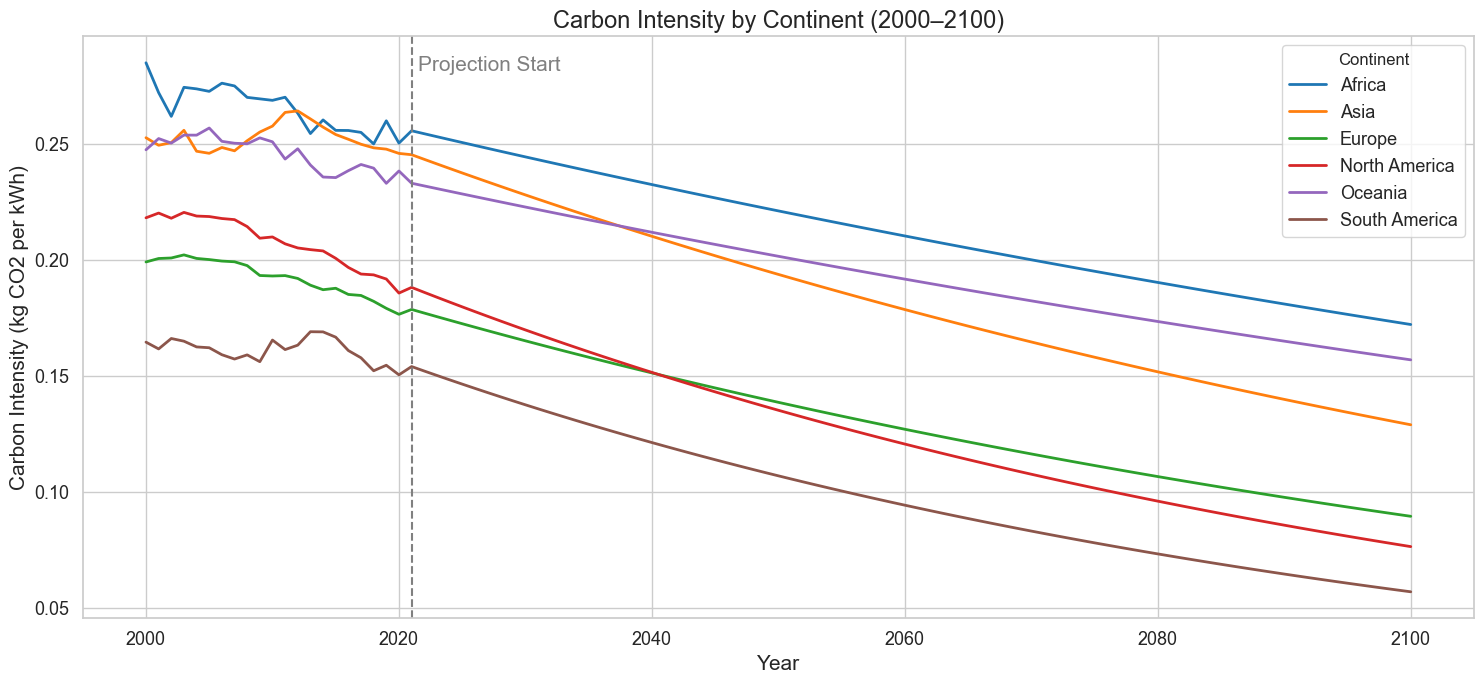

In [107]:
sns.set(style="whitegrid")

continents = full_df['Continent'].unique()
colors = sns.color_palette("tab10", len(continents))
transition_year = 2021

def plot_intensity(df, value_col, ylabel, title):
    plt.figure(figsize=(15, 7))

    for i, continent in enumerate(continents):
        subset = df[df['Continent'] == continent]
        plt.plot(subset['Year'], subset[value_col], label=continent, color=colors[i], linewidth=2)

    plt.axvline(x=transition_year, color='gray', linestyle='--', linewidth=1.5)
    plt.text(transition_year + 0.5, plt.ylim()[1]*0.95, 'Projection Start', color='gray', fontsize=15)

    plt.title(title, fontsize=17)
    plt.xlabel("Year", fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.legend(title="Continent", fontsize=13)
    plt.tight_layout()
    plt.show()

plot_intensity(
    full_df,
    value_col='energy_intensity',
    ylabel='Energy Intensity (kWh per $ GDP)',
    title='Energy Intensity by Continent (2000–2100)'
)

plot_intensity(
    full_df,
    value_col='carbon_intensity',
    ylabel='Carbon Intensity (kg CO2 per kWh)',
    title='Carbon Intensity by Continent (2000–2100)'
)